# Customer Analytics

In this project, I am going to do some customer analytics of a dataset that consists of 2000 unique individuals and their purchasing behavior of a supermarket.
In the segmentation legend file, you can find more info about each coloumn.

In the following notebooks, I will do the following:
1. Cluster analysis and dimentionality reduction
2. Desciptive statistics
3. Elasticity modeling
4. Deep learning

In the first notebook, I will do some analysis of the STP framework (segmentation, targeting and positioning).

Here is the legend of the of data:

![](Legend1.png)

![](Legend2.png)

In [106]:
# Imports
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle

In [73]:
df_segmentation = pd.read_csv("segmentation data.csv", index_col=0)
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [74]:
# Exploring the data
df_segmentation.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


## Segmentation

### Correlation

Text(0.5, 1.0, 'Correlation heatmap')

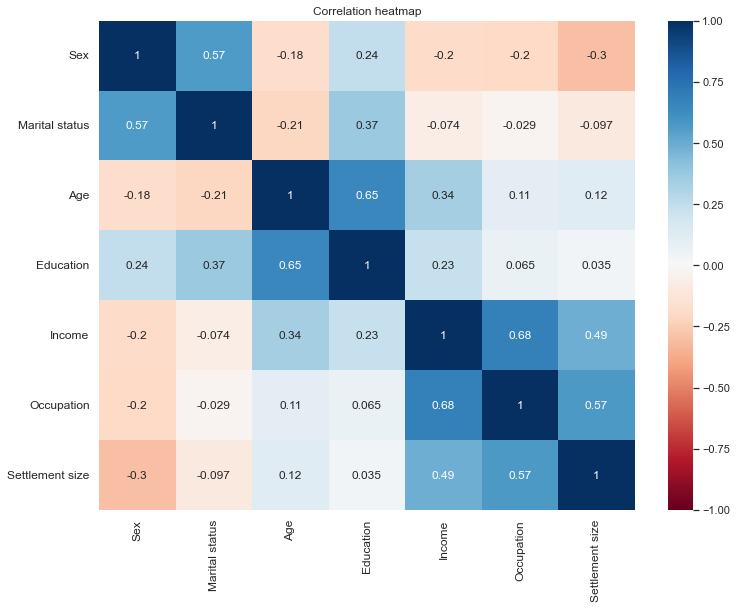

In [75]:
plt.figure(figsize=(12,9))
s = sns.heatmap(df_segmentation.corr(),
    annot=True,
    cmap="RdBu",
    vmin=-1,
    vmax=1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title("Correlation heatmap")

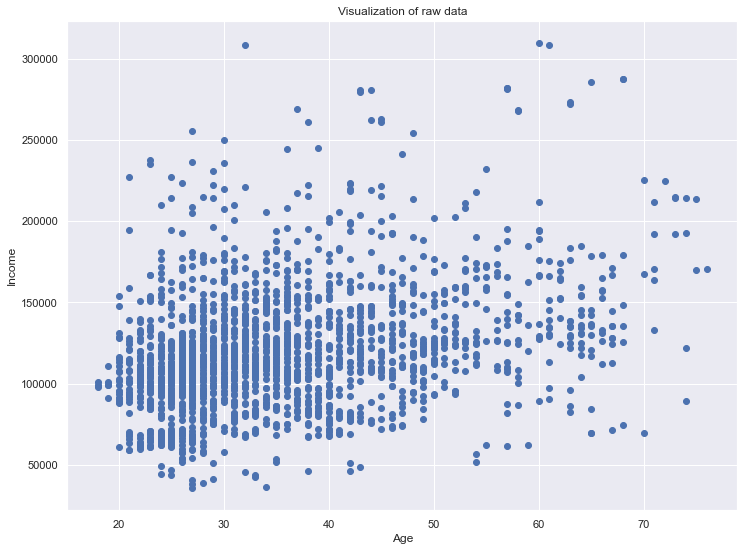

In [76]:
# Visualize Raw Data

plt.figure(figsize=(12,9))
plt.scatter(df_segmentation['Age'], df_segmentation['Income'])
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Visualization of raw data")
plt.show()

Let's standardizing our data so that every feature is weighted equally.

In [77]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

## Hierachrical Clustering

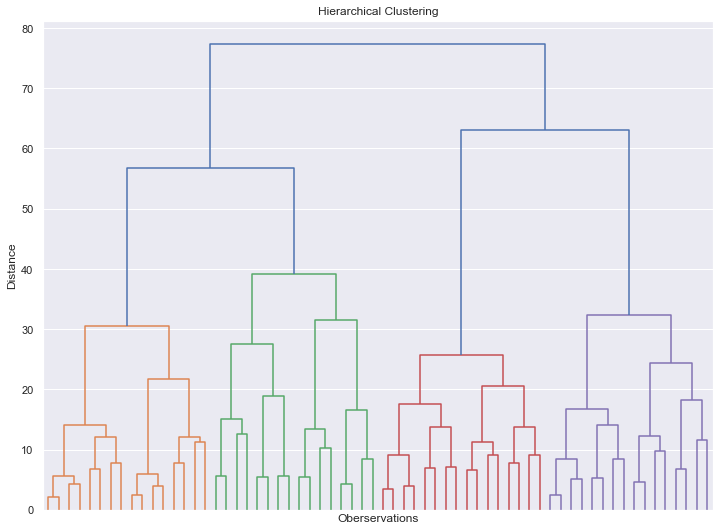

In [78]:
hier_clust = linkage(segmentation_std, method="ward")

plt.figure(figsize=(12,9))
plt.title("Hierarchical Clustering")
plt.xlabel("Oberservations")
plt.ylabel("Distance")
dendrogram(hier_clust,
    truncate_mode="level",
    p = 5,
    show_leaf_counts=False,
    no_labels=True)

plt.show()

### K-means clustering

In [79]:
# Lets find the optimal number of clusters

wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)


Text(0.5, 1.0, 'K-means clustering')

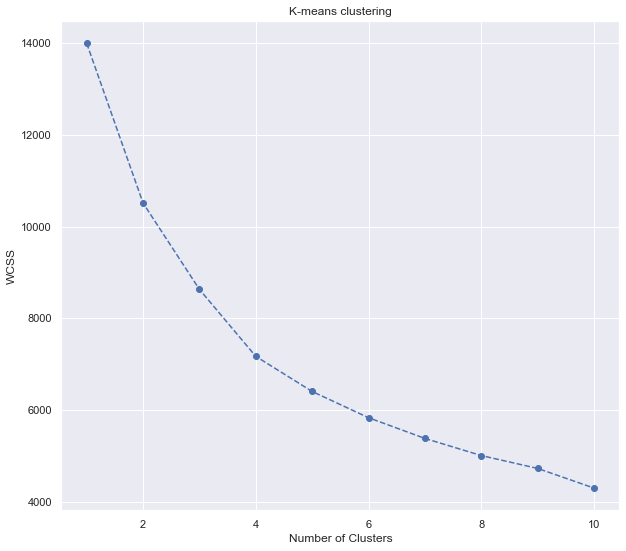

In [80]:
plt.figure(figsize=(10,9))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-means clustering")

To find the optimal number of clusters, we could use the "elbow method". We try to look for the albow and take that many clusters. The elbow seems to be at 4! So, 4 clusters

In [81]:
# Let's perform the clustering with 4 clusters.

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

# Fit the standardized data
kmeans.fit(segmentation_std)

KMeans(n_clusters=4, random_state=42)

In [82]:
df_segm_kmeans = df_segmentation.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [83]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695
3,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807


We should now label our 4 segments.
The first segment of index 0, is almost 100% married. They are the youngest segment with a normal distributed bell curve of settlement and occupation. We can call the group "Standard".
Let's label that the segments like this:

Index 0 = Well-off\
Index 1 = Fewer Opportunities\
Index 2 = Standard\
Index 3 = Career focused

In [84]:
# Let's take a look at the size/proportions of the segments

df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means', 'Sex']].groupby(['Segment K-means']).count()

In [85]:
# Proportions of the segments in %

df_segm_analysis['Proportions Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()

In [86]:
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Proportions Obs
Segment K-means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
3,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850


In [87]:
# Let's rename the segments

df_segm_analysis.rename({
    0:'Well-off',
    1:'Fewer Opportunities',
    2:'Standard',
    3: 'Career-focused'
})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Proportions Obs
Segment K-means,,,,,,,,,
Well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
Fewer Opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
Standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525
Career-focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850


In [88]:
# Let's plot the raw data

df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({
    0:'Well-off',
    1:'Fewer Opportunities',
    2:'Standard',
    3: 'Career-focused'
})

c:\Users\ml258\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


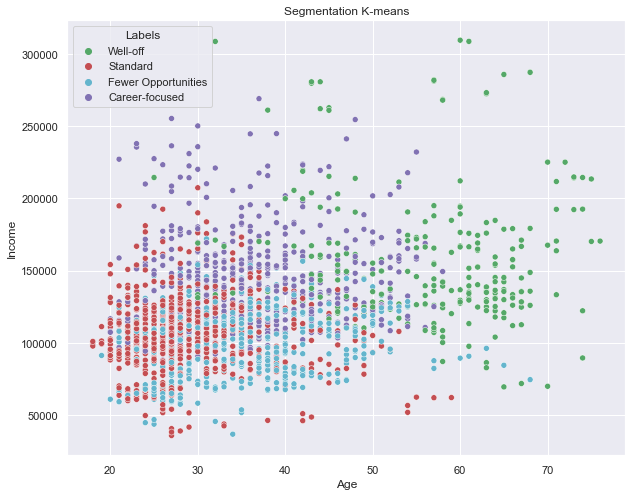

In [89]:
x_axis = df_segm_kmeans['Age']
y_axis = df_segm_kmeans['Income']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_kmeans['Labels'], palette=['g', 'r', 'c','m'])
plt.title('Segmentation K-means')
plt.show()

## PCA

In [90]:
pca = PCA()
pca.fit(segmentation_std)

PCA()

In [91]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

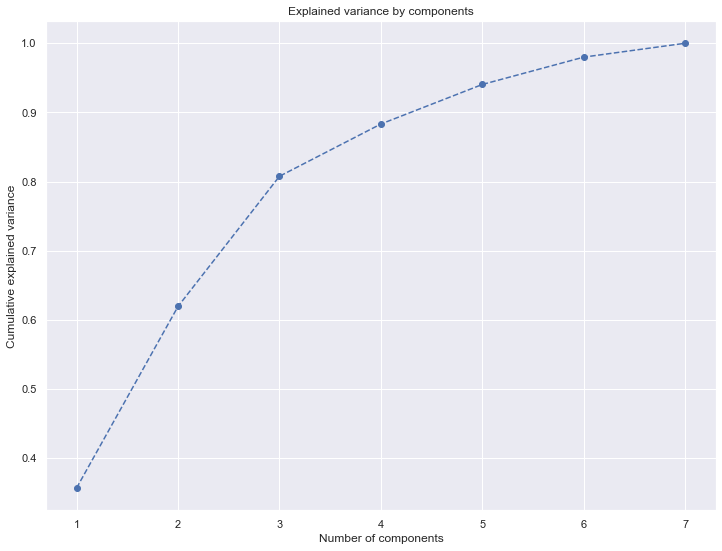

In [92]:
from pickletools import markobject


plt.figure(figsize=(12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

A rule of thumb is to keep 70-80% of the variance, so a components number of 3 or 4 is the best in this case.

In [93]:
pca = PCA(n_components = 3)
pca.fit(segmentation_std)

PCA(n_components=3)

#### PCA results

In [94]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                    columns= df_segmentation.columns.values,
                    index = ['Component 1', 'Component 2', 'Component 3'])

df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


([<matplotlib.axis.YTick at 0x2881918a130>,
 [Text(0, 1, 'Component 1'),
  Text(0, 2, 'Component 2'),
  Text(0, 3, 'Component 3')])

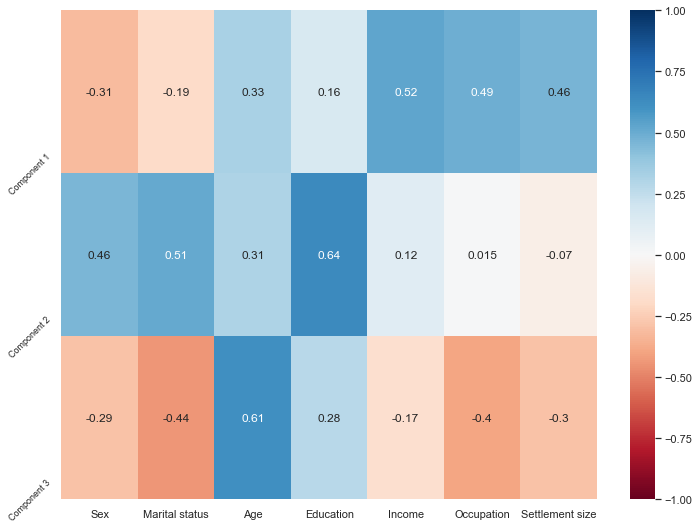

In [95]:
plt.figure(figsize=(12,9))
sns.heatmap(
    df_pca_comp,
    vmin=-1, 
    vmax=1,
    cmap='RdBu',
    annot=True,
)
plt.yticks(
    [1,2,3],
    ['Component 1', 'Component 2', 'Component 3'],
    rotation = 45, 
    fontsize=9
    )

In [96]:

scores_pca = pca.transform(segmentation_std)

### K-means clustering with PCA Results

Now, we can try K-means clustering again, just with the pca scores this time!

In [97]:
wcss = []

for i in range(1,11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

Text(0.5, 1.0, 'K-means with PCA Clustering')

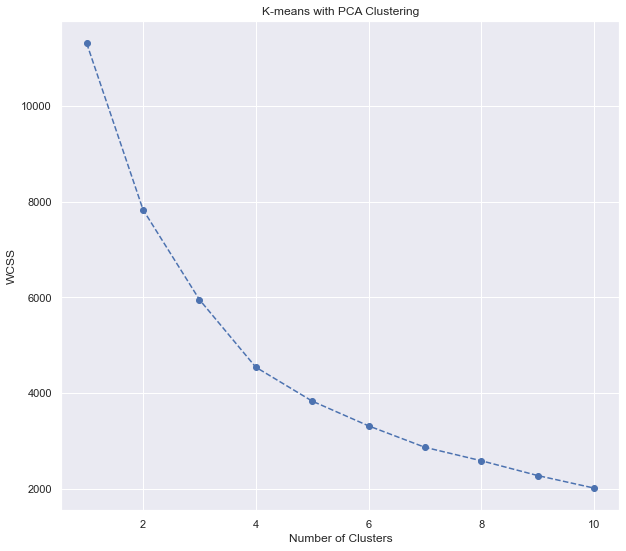

In [98]:
plt.figure(figsize=(10,9))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-means with PCA Clustering")

Seems like a cluster of 4 is still the best.

In [99]:
# We have chosen four clusters, so we run K-means with number of clusters equals four. 
# Same initializer and random state as before.
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

# We fit our data with the k-means pca model
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

### K-means clustering with PCA Results

In [100]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
# The last column we add contains the pca k-means clustering labels.
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [101]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,2
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,0
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,2
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,0


In [102]:
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410
1,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046
2,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644
3,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039


In [103]:
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,
standard,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410,692,0.3460
career focused,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915
fewer opportunities,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644,460,0.2300
well-off,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039,265,0.1325


In [104]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})

c:\Users\ml258\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


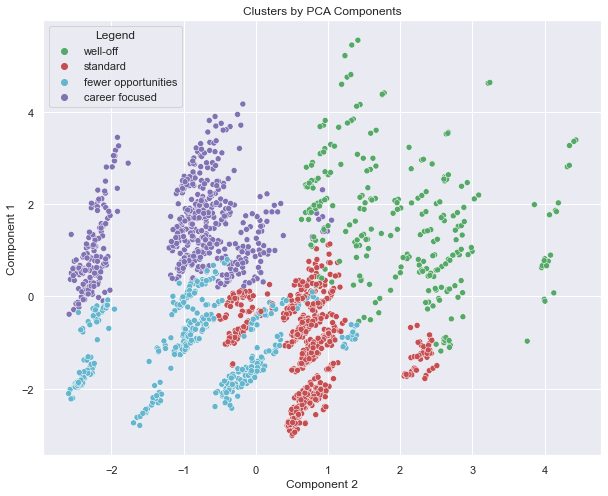

In [105]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

### Data export

In [107]:
pickle.dump(scaler, open('scaler.pickle', 'wb'))

In [108]:
pickle.dump(pca, open('pca.pickle', 'wb'))

In [109]:
pickle.dump(kmeans_pca, open('kmeans_pca.pickle', 'wb'))